## Important

`run_mafft.sh` and `run_raxml.sh` in each subfoloder of `Trees` to build the trees beforehand.

In [2]:
library(ape)
library(sitePath)
library(tibble)
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(ggtree))

METADATA_DIR <- "Metadata"
TREES_DIR <- "Trees"
PLOTS_DIR <- "Plots"

H1N1_HA_NAME <- "H1N1_HA"
H3N2_HA_NAME <- "H3N2_HA"
H3N2_HA1_PRE2010_NAME <- "H3N2_HA1_pre2003"
ZIKV_POLYPROTEIN_NAME <- "ZIKV_polyprotein"
SARS_COV_2_CDS_NAME <- "SARS_CoV_2_cds"

H3N2_HA_TREE_DIR <- file.path(TREES_DIR, H3N2_HA_NAME)
H3N2_HA1_PRE2010_TREE_DIR <- file.path(TREES_DIR, H3N2_HA1_PRE2010_NAME)

dir.create(PLOTS_DIR, showWarnings = FALSE)

### 1. H3N2 HA1 pre2010

In [2]:
treeDir <- file.path(TREES_DIR, H3N2_HA1_PRE2010_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [3]:
clusterInfo <- read.csv(file.path(METADATA_DIR, paste0(H3N2_HA1_PRE2010_NAME, ".csv")), stringsAsFactors = FALSE)

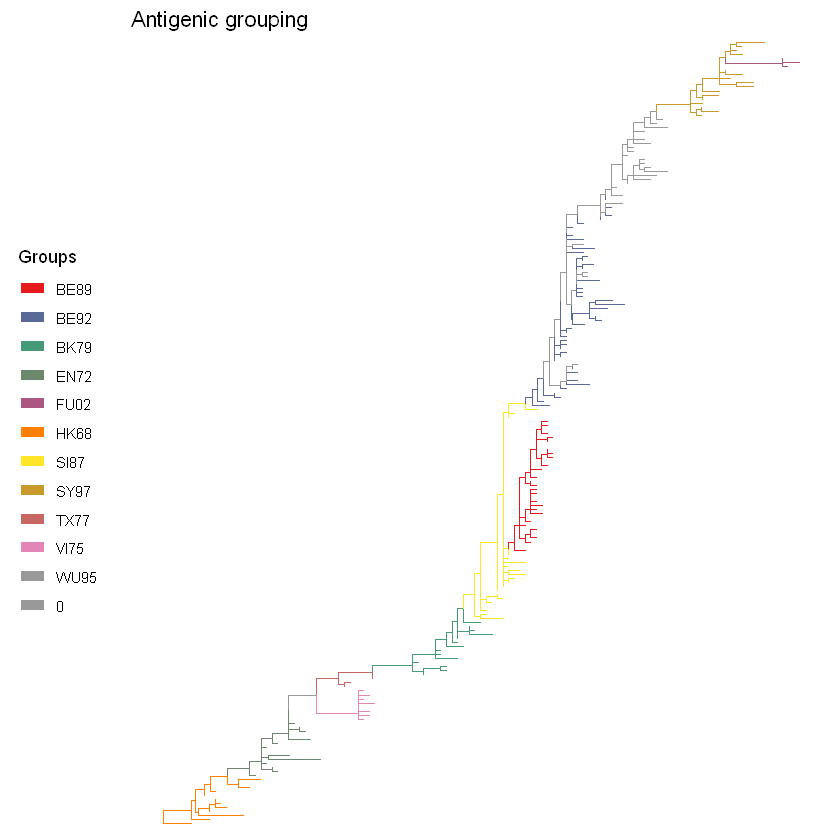

In [4]:
group <- split(clusterInfo[["id"]], clusterInfo[["cluster"]])

groupColors <- colorRampPalette(brewer.pal(9, "Set1"))(length(group))
names(groupColors) <- names(group)
groupColors["0"] <- "#999999"

p <- ggtree(groupOTU(tree, group), aes(color = group)) +
    theme(legend.position = "left") +
    ggtitle("Antigenic grouping") +
    scale_color_manual(values = as.list(groupColors), limits = names(groupColors)) +
    guides(
      color = guide_legend(
        override.aes = list(size = 3),
        title = 'Groups'
      )
    )
p
ggsave(
    filename = file.path(PLOTS_DIR, paste0(H3N2_HA1_PRE2010_NAME, "_cluster.pdf")), 
    plot = p, device = "pdf", width = 7, height = 10
)

In [5]:
paths <- lineagePath(tree, similarity = 0.07)

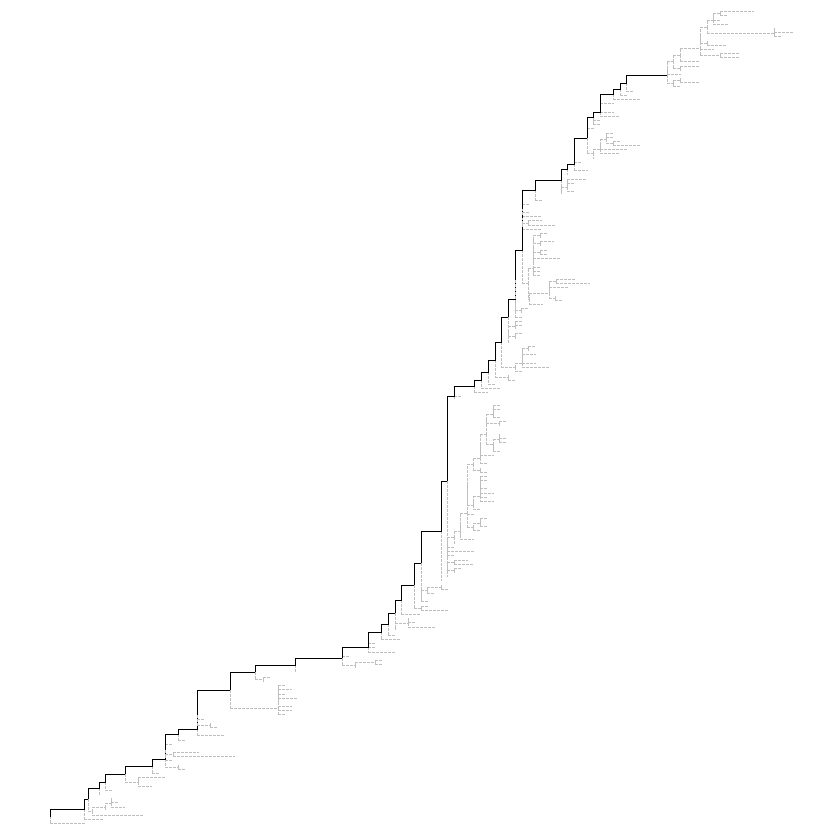

In [6]:
attr(tree, "group") <- rep(1, times = Ntip(tree) + tree$Nnode)
attr(tree, "group")[unique(unlist(paths))] <- 0
attr(tree, "group") <- factor(attr(tree, "group"))

ggtree(tree, aes(color=group, linetype=group)) + 
    scale_color_manual(values = c("black", "grey")) + 
    theme(legend.position = "none")

In [7]:
mutations <- fixationSites(paths)

In [8]:
snpTracing <- as.phylo(mutations)

In [9]:
d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function(snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        n <- attr(snp, "edge")[2]
        children <- sitePath:::.childrenTips(snpTracing, n)
        children <- getMRCA(tree, unlist(attr(snpTracing, "tipClusters")[children]))
        res <- c(res, children)
        names(res) <- c("SNPs", "node")
        return(res)
    },
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])
d <- na.omit(d)
d <- d[which(!duplicated(d[["node"]])), ]

x <- as_tibble(tree)
y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

In [10]:
checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 195 
Found number of nodes: m = 194 
Done.


Warning message:
"Removed 378 rows containing missing values (geom_label_repel)."


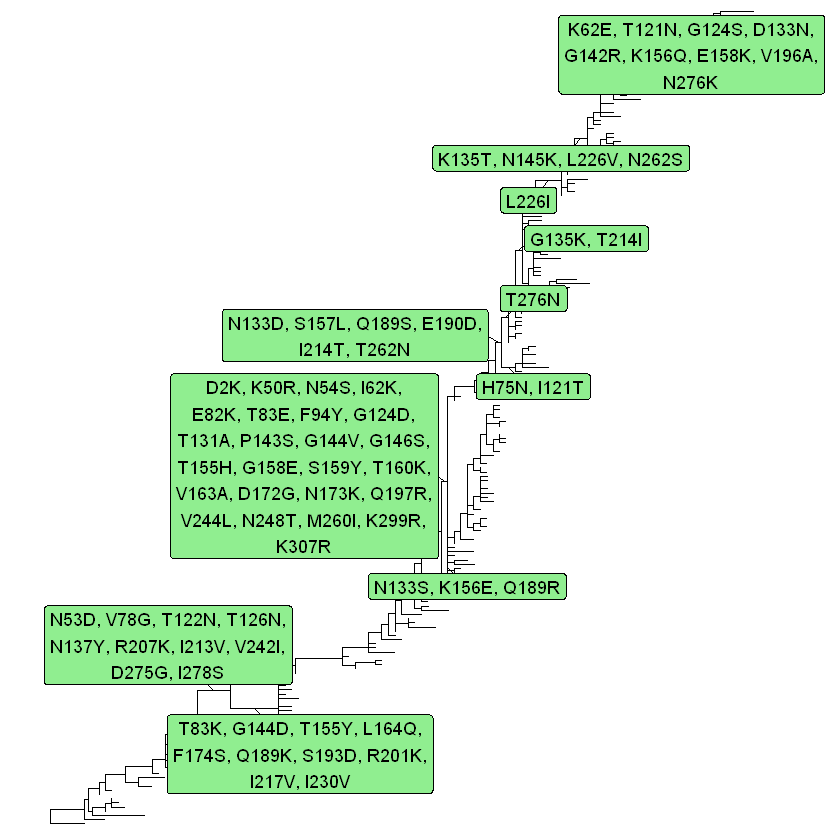

In [14]:
ggtree(tr) +
    geom_label_repel(
        aes(x=branch, label=SNPs),
        fill='lightgreen',
        min.segment.length = 0
    )

In [9]:
x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tree <- as.treedata(y)

Warning message:
"Removed 5 rows containing missing values (geom_label_repel)."


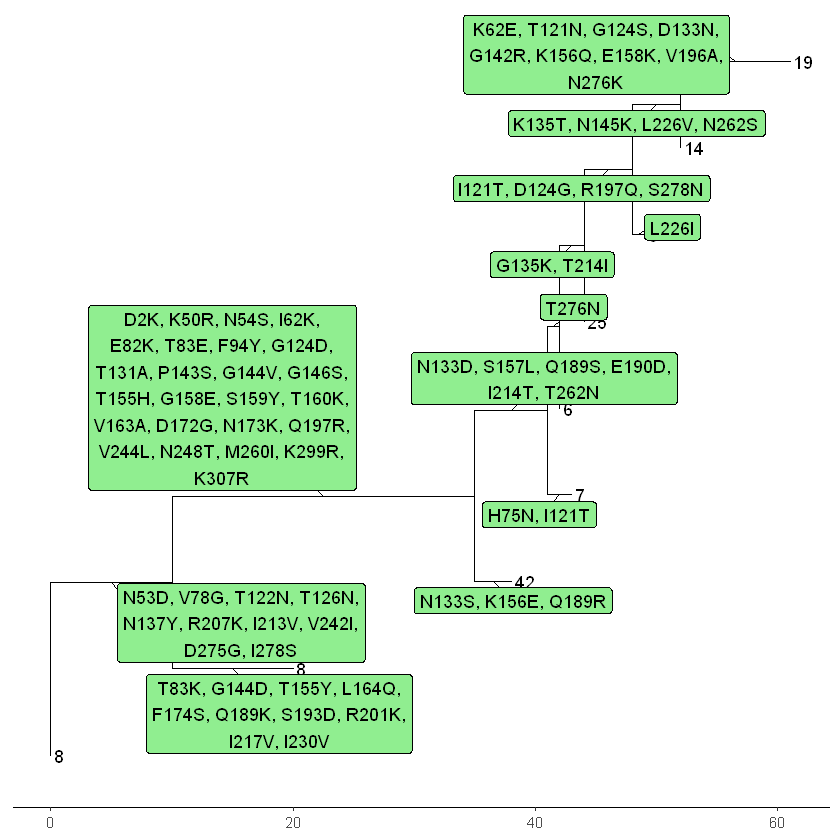

In [10]:
ggtree(tree) + geom_tiplab() +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0) + theme_tree2()

### 2. ZIKV polyprotein

In [2]:
treeDir <- file.path(TREES_DIR, ZIKV_POLYPROTEIN_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [3]:
paths <- lineagePath(tree, 0.05)

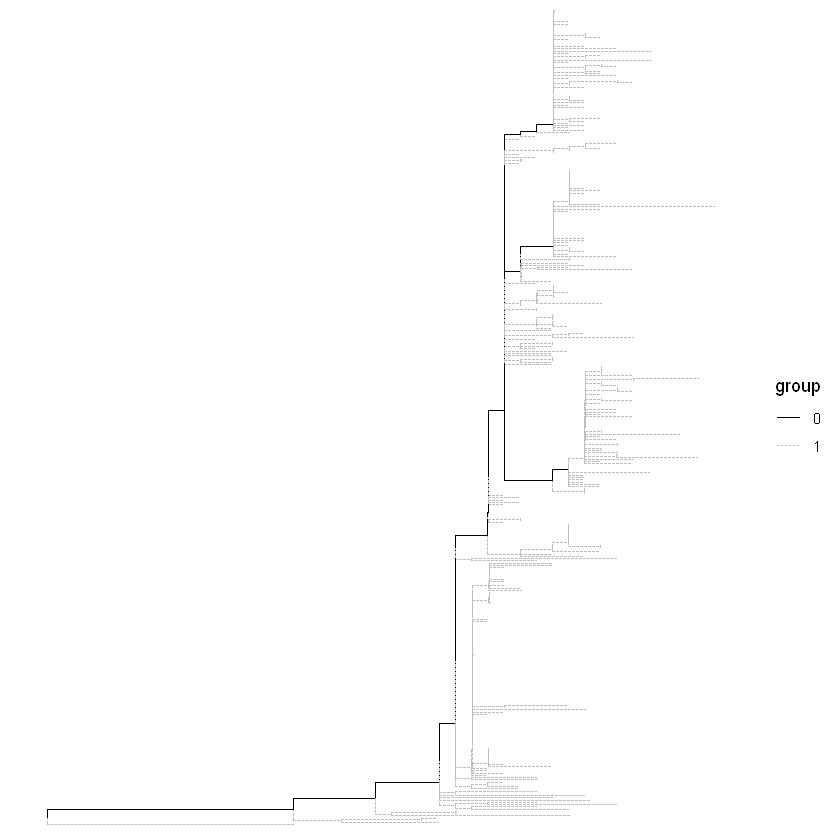

In [53]:
attr(tree, "group") <- rep(1, times = Ntip(tree) + tree$Nnode)
attr(tree, "group")[unique(unlist(paths))] <- 0
attr(tree, "group") <- factor(attr(tree, "group"))

ggtree(tree, aes(color=group, linetype=group)) + scale_color_manual(values = c("black", "grey"))

In [4]:
mutations <- fixationSites(paths)

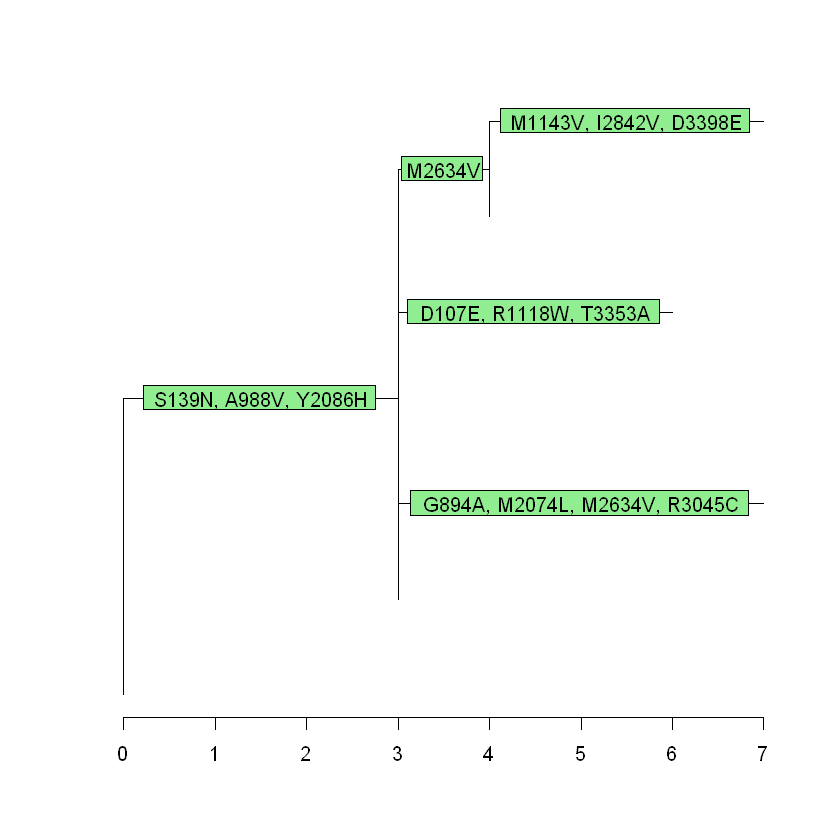

In [49]:
plot(mutations)

### 3. SARS-CoV-2 CDS

In [11]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(SARS_COV_2_CDS_NAME, ".csv")), 
    row.names = "Accession.ID",
    stringsAsFactors = FALSE
)

In [12]:
treeDir <- file.path(TREES_DIR, SARS_COV_2_CDS_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.GTRGAMMA"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

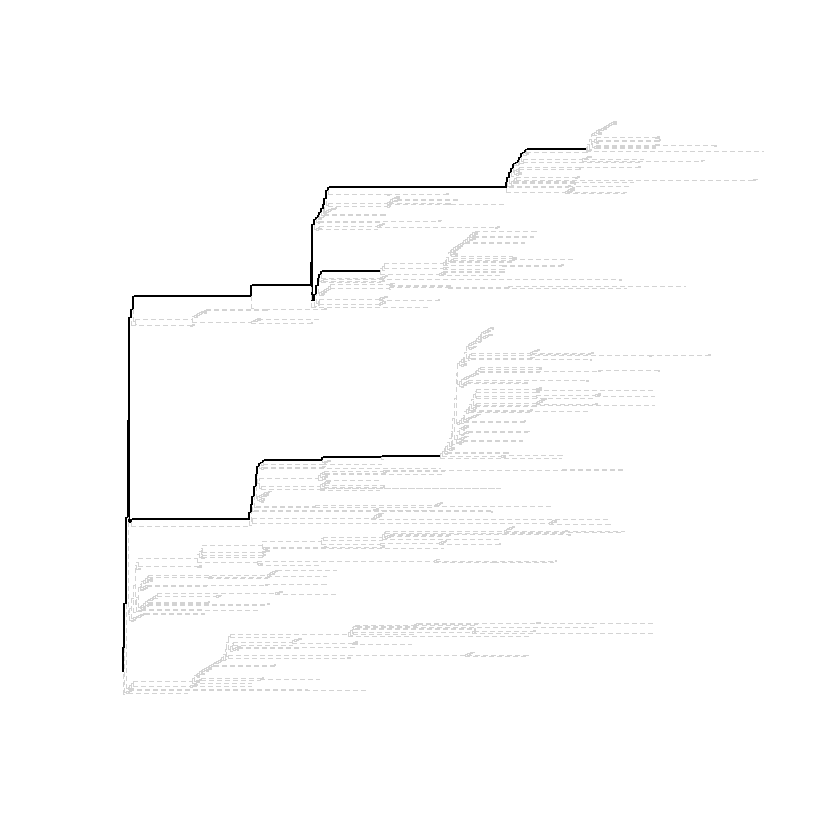

In [13]:
paths <- lineagePath(tree, similarity = 0.03)
plot(paths)

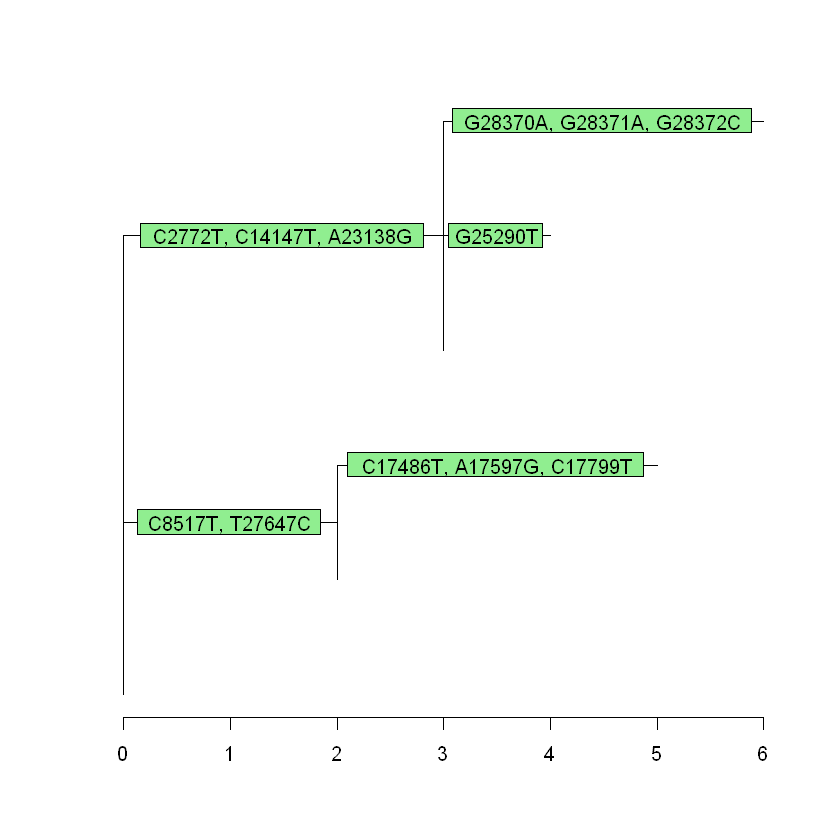

In [14]:
mutations <- fixationlineages(paths)
plot(mutations)

### 1. H1N1 HA

In [3]:
treeDir <- file.path(TREES_DIR, H1N1_HA_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "MK615591")
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

pdf(file = file.path(PLOTS_DIR, paste0(H1N1_HA_NAME, ".pdf")), width = 15, height = 50)
plot(ladderize(tree), cex = 0.15)
invisible(dev.off())

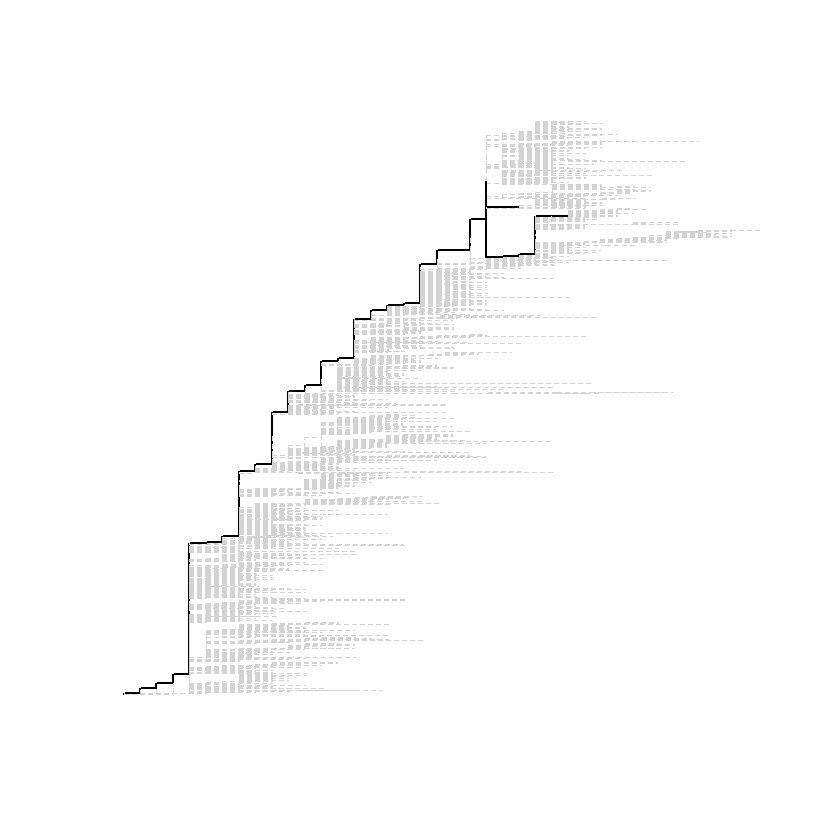

In [4]:
paths <- lineagePath(tree, 0.01)
plot(paths)

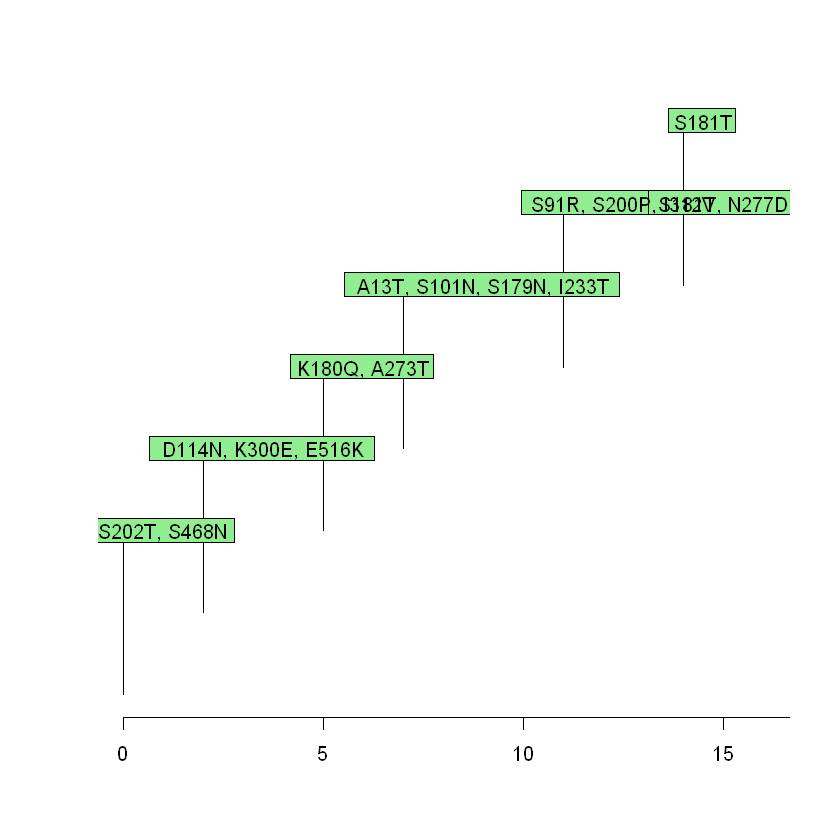

In [10]:
mutations <- fixationSites(paths)
plot(mutations)

### 2. H3N2

In [18]:
tree <- read.tree(file.path(H3N2_HA_TREE_DIR, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "AB284320")
tree <- addMSA(tree, msaPath = file.path(H3N2_HA_TREE_DIR, "aligned.fasta"), msaFormat = "fasta")

pdf(file = file.path(PLOTS_DIR, paste0(H3N2_HA_NAME, ".pdf")), width = 15, height = 50)
plot(ladderize(tree), cex = 0.15)
invisible(dev.off())

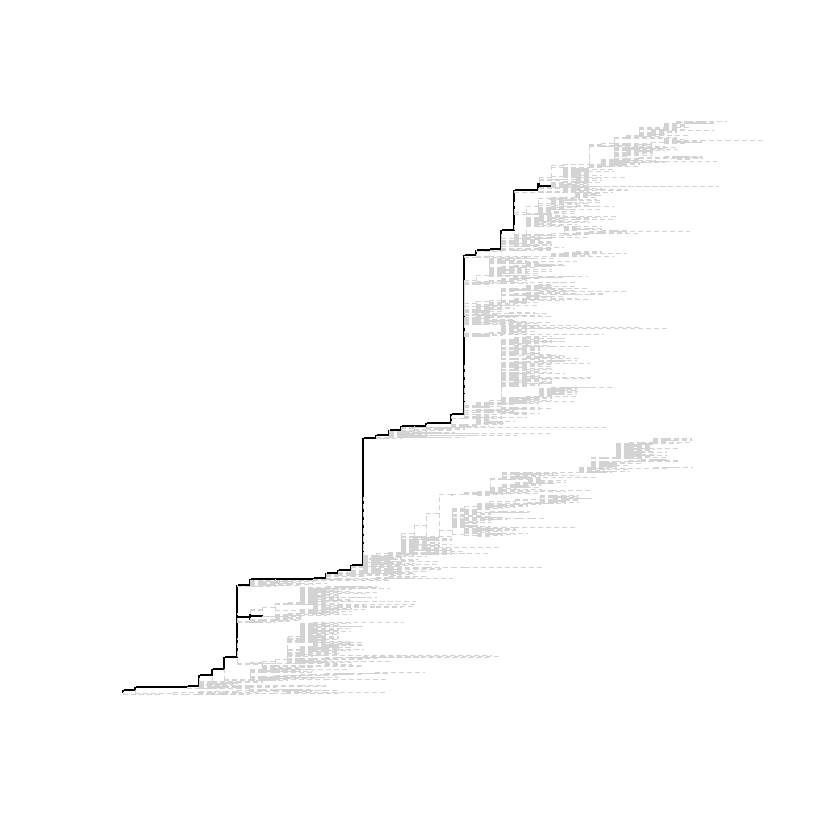

In [19]:
paths <- lineagePath(tree, 0.01)
plot(paths)

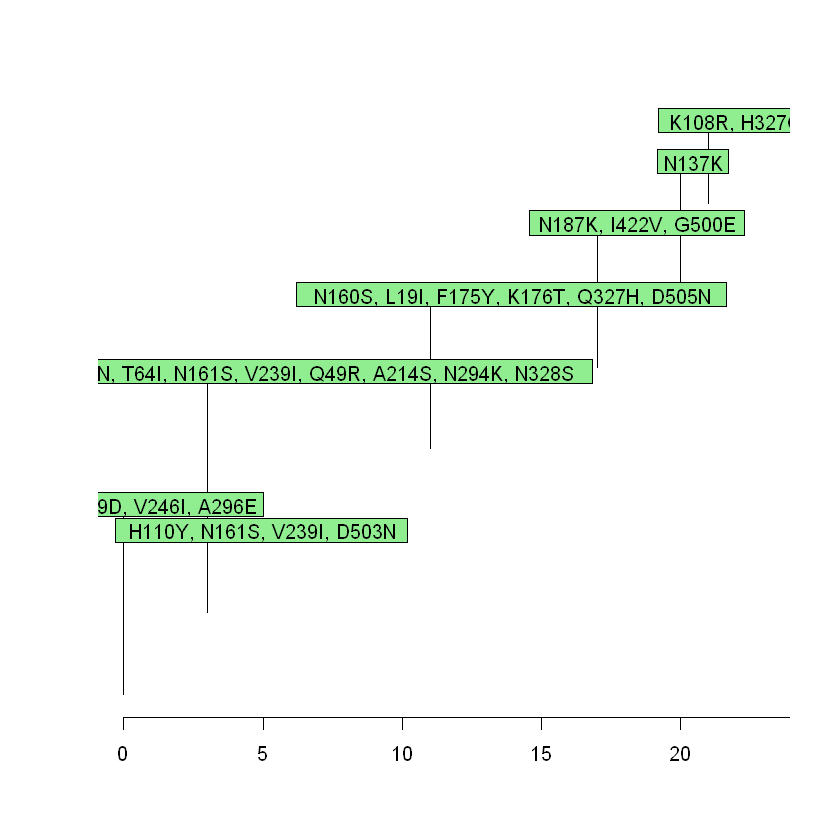

In [20]:
mutations <- fixationSites(paths)
plot(mutations)